In [4]:
!pip install --upgrade yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/4b/fb/2b6290436f0188d1f1d51c8076e32c9c50f24afa1c698430394eead3a890/yfinance-0.2.63-py2.py3-none-any.whl.metadata
  Obtaining dependency information for curl_cffi>=0.7 from https://files.pythonhosted.org/packages/8a/4a/e48bb17ff51025addcd6c85efbc144636199cead71809c02d7cc4abd3229/curl_cffi-0.11.4-cp39-abi3-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for websockets>=13.0 from https://files.pythonhosted.org/packages/86/f2/10b55821dd40eb696ce4704a87d57774696f9451108cff0d2824c97e0f97/websockets-15.0.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstal

# Backtesting EMA Crossback Strategy

## EMA Crossback Strategy - Based on the cycle of price action devised by Oliver Kell 

### OLIVER KELL is the 2020 US Investing Champion with a 941.10% annualized return.

# Cycle of Price Action -

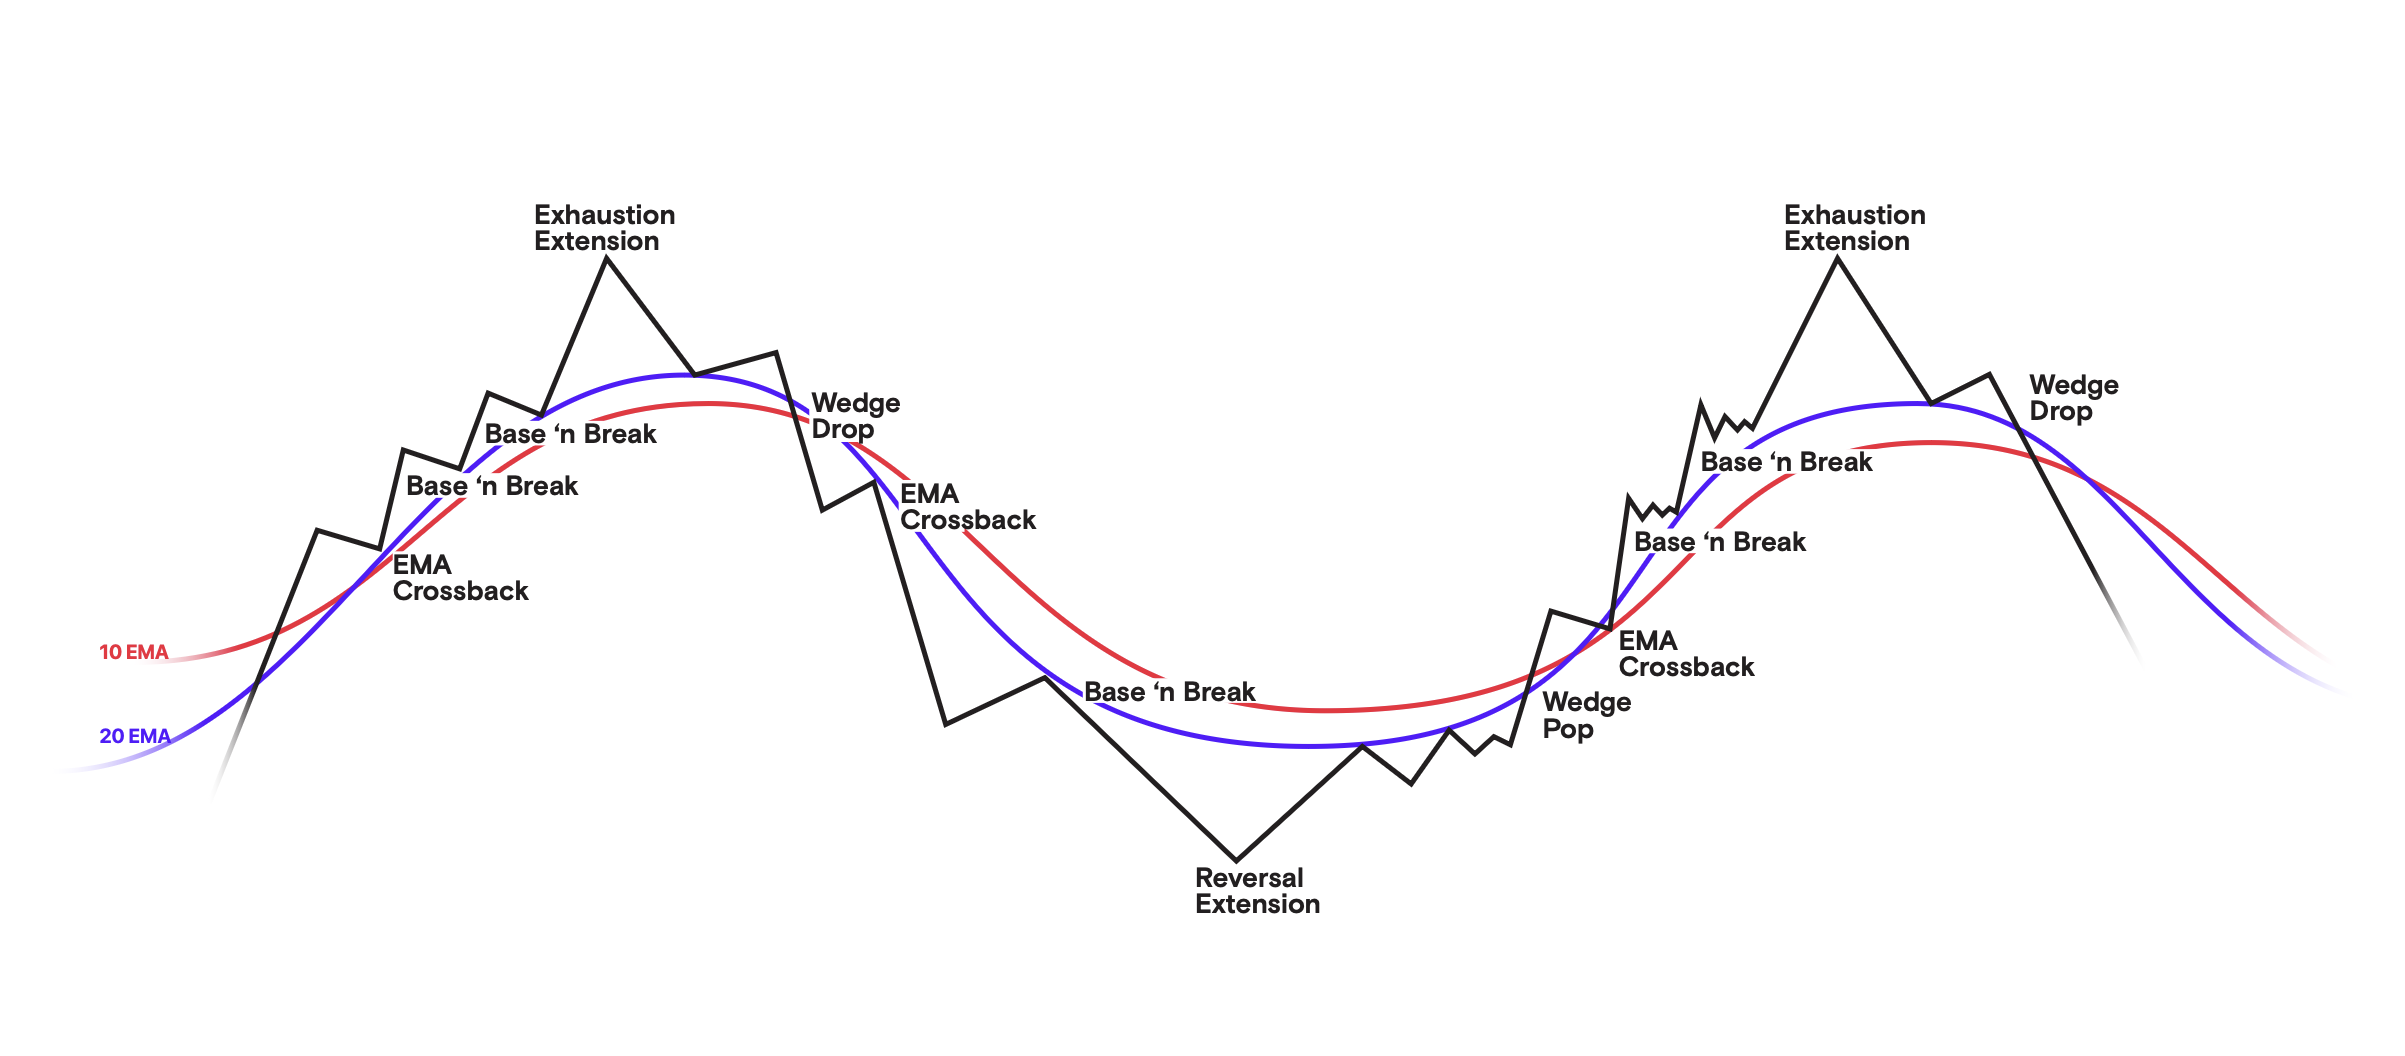

In [24]:

from IPython import display

display.Image('/Users/apoorvsharma/Desktop/Sterling Management and Capital Holdings/Screenshots/Oliver Kell.png')

The Strategy being tested is triggered at the phase - EMA Crossback - we would buy the stock when the 20 EMA crosses over the 10 EMA. Ideal point of exiting the position is during confirmation of Exhaustion extension and a reversal of the ongoing trend.


Risk per trade is kept at 5% 

Stop Loss is kept at 7% 

Profit booking happens at 30% 

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time

In [21]:
class KellStrategyBacktest:
    def __init__(self, symbol, start_date, end_date, initial_capital=1000):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.initial_capital = initial_capital
        self.current_capital = initial_capital
        self.position = 0
        self.trades = []
        self.data = None
        
    def fetch_data(self, max_retries=3, delay=2):
        """Fetch historical data and calculate technical indicators with retry logic"""
        for attempt in range(max_retries):
            try:
                ticker = yf.Ticker(self.symbol)
                self.data = ticker.history(start=self.start_date, end=self.end_date)
                
                if self.data.empty:
                    raise ValueError(f"No data retrieved for {self.symbol}")
                
                # Calculate EMAs
                self.data['EMA10'] = self.data['Close'].ewm(span=10, adjust=False).mean()
                self.data['EMA20'] = self.data['Close'].ewm(span=20, adjust=False).mean()
                
                # Calculate volatility
                self.data['Daily_Return'] = self.data['Close'].pct_change()
                self.data['Volatility'] = self.data['Daily_Return'].rolling(window=20).std()
                
                return self.data
                
            except Exception as e:
                if attempt == max_retries - 1:
                    raise Exception(f"Failed to fetch data after {max_retries} attempts: {str(e)}")
                print(f"Attempt {attempt + 1} failed, retrying in {delay} seconds...")
                time.sleep(delay)
                delay *= 2  # Exponential backoff
    
    def identify_base_n_break(self, window=20):
        """Identify Base 'n Break patterns"""
        if self.data is None or self.data.empty:
            raise ValueError("No data available for analysis")
            
        self.data['Price_Range'] = self.data['High'] - self.data['Low']
        self.data['Avg_Range'] = self.data['Price_Range'].rolling(window=window).mean()
        self.data['Base'] = (self.data['Price_Range'] < self.data['Avg_Range'] * 0.8).astype(int)
        
        # Calculate base sum for last 5 days
        base_sum = self.data['Base'].rolling(window=5).sum()
        
        # Identify break conditions
        break_price = self.data['Close'] > self.data['High'].shift(1)
        break_base = base_sum >= 3
        
        # Combine conditions
        self.data['Break'] = (break_price & break_base).astype(int)
        
        return self.data
    
    def identify_ema_crossback(self):
        """Identify EMA Crossback patterns"""
        if self.data is None or self.data.empty:
            raise ValueError("No data available for analysis")
            
        self.data['EMA_Cross'] = (self.data['Close'] > self.data['EMA10']) & \
                                (self.data['Close'] > self.data['EMA20']) & \
                                (self.data['Close'].shift(1) <= self.data['EMA10'].shift(1))
        return self.data
    
    def calculate_position_size(self, price):
        """Calculate position size based on risk management"""
        if price <= 0:
            raise ValueError("Invalid price for position calculation")
            
        risk_per_trade = 0.05  # 5% risk per trade
        stop_loss_percent = 0.07  # 7% stop loss
        
        risk_amount = self.current_capital * risk_per_trade
        shares = int(risk_amount / (price * stop_loss_percent))
        return min(shares, int(self.current_capital / price))
    
    def execute_trade(self, row, signal_type):
        """Execute trade based on signal"""
        try:
            price = row['Close']
            if self.position == 0 and price > 0:  # If no position and valid price, consider entry
                shares = self.calculate_position_size(price)
                if shares > 0:
                    self.position = shares
                    stop_loss = price * 0.93 # 7% stop loss
                    take_profit = price * 1.30  # 30% take profit
                    self.trades.append({
                        'date': row.name,
                        'type': 'buy',
                        'price': price,
                        'shares': shares,
                        'signal': signal_type,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit,
                        'capital': self.current_capital
                    })
        except Exception as e:
            print(f"Error executing trade: {str(e)}")
    
    def run_backtest(self):
        """Run the backtest"""
        try:
            self.fetch_data()
            self.identify_base_n_break()
            self.identify_ema_crossback()
            
            for index, row in self.data.iterrows():
                # Check for exit conditions if in position
                if self.position > 0:
                    # Check stop loss and take profit
                    last_trade = self.trades[-1]
                    if row['Low'] <= last_trade['stop_loss']:
                        # Stop loss hit
                        self.current_capital -= self.position * (last_trade['price'] - last_trade['stop_loss'])
                        self.position = 0
                        self.trades.append({
                            'date': index,
                            'type': 'sell',
                            'price': last_trade['stop_loss'],
                            'shares': last_trade['shares'],
                            'signal': 'stop_loss',
                            'capital': self.current_capital
                        })
                    elif row['High'] >= last_trade['take_profit']:
                        # Take profit hit
                        self.current_capital += self.position * (last_trade['take_profit'] - last_trade['price'])
                        self.position = 0
                        self.trades.append({
                            'date': index,
                            'type': 'sell',
                            'price': last_trade['take_profit'],
                            'shares': last_trade['shares'],
                            'signal': 'take_profit',
                            'capital': self.current_capital
                        })
                
                # Check for entry signals
                if self.position == 0:
                    if row['Break']:
                        self.execute_trade(row, 'base_n_break')
                    elif row['EMA_Cross']:
                        self.execute_trade(row, 'ema_crossback')
            
            return self.analyze_results()
            
        except Exception as e:
            print(f"Backtest failed: {str(e)}")
            return None
    
    def analyze_results(self):
        """Analyze backtest results"""
        if not self.trades:
            return "No trades executed"
            
        trades_df = pd.DataFrame(self.trades)
        print(trades_df)
        
        results = {
            'Initial Capital': self.initial_capital,
            'Final Capital': self.current_capital,
            'Total Return %': ((self.current_capital - self.initial_capital) / self.initial_capital) * 100,
            'Number of Trades': len(trades_df[trades_df['type'] == 'buy']),        
            'Win Rate': len(trades_df[trades_df['signal'] == 'take_profit']) / \
                       len(trades_df[trades_df['type'] == 'sell']) * 100 if len(trades_df[trades_df['type'] == 'sell']) > 0 else 0
        }
        return results

def run_strategy(symbol, start_date, end_date, initial_capital=1000):
    try:
        backtest = KellStrategyBacktest(
            symbol=symbol,
            start_date=start_date,
            end_date=end_date,
            initial_capital=initial_capital
        )
        results = backtest.run_backtest()
        return results
    except Exception as e:
        print(f"Strategy execution failed for {symbol}: {str(e)}")
        return None

# Comparing the performance of the strategy over 4 years for TSLA 

In [25]:
# Create backtest instance
backtest = KellStrategyBacktest('TSLA', '2020-01-01', '2020-12-31', 1000)

# Run backtest and print results
results = backtest.run_backtest()

print(results)

                        date  type       price  shares         signal  \
0  2020-01-03 00:00:00-05:00   buy   29.534000      24  ema_crossback   
1  2020-01-22 00:00:00-05:00  sell   38.394201      24    take_profit   
2  2020-02-18 00:00:00-05:00   buy   57.226665      15   base_n_break   
3  2020-02-25 00:00:00-05:00  sell   53.220799      15      stop_loss   
4  2020-04-07 00:00:00-04:00   buy   36.363335      22   base_n_break   
5  2020-04-14 00:00:00-04:00  sell   47.272335      22    take_profit   
6  2020-04-14 00:00:00-04:00   buy   47.326000      21   base_n_break   
7  2020-06-08 00:00:00-04:00  sell   61.523800      21    take_profit   
8  2020-06-25 00:00:00-04:00   buy   65.732002      18  ema_crossback   
9  2020-07-06 00:00:00-04:00  sell   85.451603      18    take_profit   
10 2020-07-27 00:00:00-04:00   buy  102.639999      14  ema_crossback   
11 2020-07-31 00:00:00-04:00  sell   95.455199      14      stop_loss   
12 2020-08-03 00:00:00-04:00   buy   99.000000     

In [26]:
# Create backtest instance
backtest = KellStrategyBacktest('TSLA', '2021-01-01', '2021-12-31', 1000)

# Run backtest and print results
results = backtest.run_backtest()

print(results)

                        date  type       price  shares         signal  \
0  2021-01-05 00:00:00-05:00   buy  245.036667       2  ema_crossback   
1  2021-02-23 00:00:00-05:00  sell  227.884100       2      stop_loss   
2  2021-03-15 00:00:00-04:00   buy  235.979996       2   base_n_break   
3  2021-03-17 00:00:00-04:00  sell  219.461396       2      stop_loss   
4  2021-03-17 00:00:00-04:00   buy  233.936661       2  ema_crossback   
5  2021-03-18 00:00:00-04:00  sell  217.561095       2      stop_loss   
6  2021-03-22 00:00:00-04:00   buy  223.333328       2   base_n_break   
7  2021-03-25 00:00:00-04:00  sell  207.699995       2      stop_loss   
8  2021-03-31 00:00:00-04:00   buy  222.643326       2  ema_crossback   
9  2021-05-11 00:00:00-04:00  sell  207.058293       2      stop_loss   
10 2021-05-20 00:00:00-04:00   buy  195.593338       3   base_n_break   
11 2021-09-08 00:00:00-04:00  sell  254.271339       3    take_profit   
12 2021-09-22 00:00:00-04:00   buy  250.646667     

In [27]:
# Create backtest instance
backtest = KellStrategyBacktest('TSLA', '2023-01-01', '2023-12-31', 1000)

# Run backtest and print results
results = backtest.run_backtest()

print(results)

                        date  type       price  shares         signal  \
0  2023-01-04 00:00:00-05:00   buy  113.639999       6  ema_crossback   
1  2023-01-06 00:00:00-05:00  sell  105.685199       6      stop_loss   
2  2023-02-22 00:00:00-05:00   buy  200.860001       3  ema_crossback   
3  2023-03-02 00:00:00-05:00  sell  186.799801       3      stop_loss   
4  2023-03-03 00:00:00-05:00   buy  197.789993       3   base_n_break   
5  2023-03-08 00:00:00-05:00  sell  183.944694       3      stop_loss   
6  2023-03-16 00:00:00-04:00   buy  184.130005       3   base_n_break   
7  2023-04-20 00:00:00-04:00  sell  171.240905       3      stop_loss   
8  2023-05-05 00:00:00-04:00   buy  170.059998       3   base_n_break   
9  2023-06-05 00:00:00-04:00  sell  221.077997       3    take_profit   
10 2023-06-28 00:00:00-04:00   buy  256.239990       2  ema_crossback   
11 2023-08-11 00:00:00-04:00  sell  238.303191       2      stop_loss   
12 2023-09-05 00:00:00-04:00   buy  256.489990     

In [29]:
# Create backtest instance
backtest = KellStrategyBacktest('TSLA', '2024-01-01', '2024-12-31', 1000)

# Run backtest and print results
results = backtest.run_backtest()

print(results)

                        date  type       price  shares         signal  \
0  2024-02-14 00:00:00-05:00   buy  188.710007       3   base_n_break   
1  2024-03-06 00:00:00-05:00  sell  175.500306       3      stop_loss   
2  2024-03-20 00:00:00-04:00   buy  175.660004       3   base_n_break   
3  2024-04-03 00:00:00-04:00  sell  163.363803       3      stop_loss   
4  2024-04-11 00:00:00-04:00   buy  174.600006       3  ema_crossback   
5  2024-04-15 00:00:00-04:00  sell  162.378006       3      stop_loss   
6  2024-04-23 00:00:00-04:00   buy  144.679993       4   base_n_break   
7  2024-04-29 00:00:00-04:00  sell  188.083990       4    take_profit   
8  2024-05-14 00:00:00-04:00   buy  177.550003       4   base_n_break   
9  2024-07-02 00:00:00-04:00  sell  230.815004       4    take_profit   
10 2024-07-22 00:00:00-04:00   buy  251.509995       3  ema_crossback   
11 2024-07-24 00:00:00-04:00  sell  233.904295       3      stop_loss   
12 2024-07-29 00:00:00-04:00   buy  232.100006     